In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
import wandb

/home/sgururaj/miniconda3/envs/amr2/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [2]:
pd.options.display.max_rows = 150

In [3]:
api = wandb.Api(timeout=20)

In [4]:
filters = {
    "state": "finished"
}

# from-scratch sweep
sweeps = ["40h94d3l", "lcb73fck", "3oh0rbcd", "eomd5a2e"]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/narrative-flow-simplified/{sweep_id}")
    runs.extend(sweep.runs)

In [5]:
df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        df_dicts.append({**run.config, "test_f1": test_f1})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

  0%|          | 0/144 [00:00<?, ?it/s]

In [6]:
results_df.head()

,lr,gnn,case,seed,epochs,fewshot,patience,base_path,gnn_depth,batch_size,...,wandb_project,use_graph_data,checkpoint_folder,experiment_config,graph_data_source,graph_connection_type,grad_accumulation_steps,train_dataset_instances,train_dataset_instance_hash,test_f1
0,0.00002,rgcn,dep_residual,2,30,100,5,/home/sgururaj/src/flow_graphs/,4,4,...,narrative-flow-simplified,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[3619, 1152, 2713, 516, 2681, 1125, 2090, 2865...",-7181305545752703268,0.723839
1,0.00002,rgcn,dep_residual,1,30,100,5,/home/sgururaj/src/flow_graphs/,4,4,...,narrative-flow-simplified,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[2573, 1931, 1063, 837, 515, 1178, 1073, 661, ...",-6184697335117306283,0.812458
2,0.00002,rgcn,dep_residual,0,30,100,5,/home/sgururaj/src/flow_graphs/,4,4,...,narrative-flow-simplified,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[2747, 236, 10, 2544, 1337, 3026, 3329, 2949, ...",8172644407290843094,0.773820
3,0.00002,rgcn,dep_residual,2,30,50,5,/home/sgururaj/src/flow_graphs/,4,4,...,narrative-flow-simplified,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[2188, 448, 2658, 1523, 2061, 1076, 2212, 2997...",1680451459040988611,0.681381
4,0.00002,rgcn,dep_residual,1,30,50,5,/home/sgururaj/src/flow_graphs/,4,4,...,narrative-flow-simplified,True,/home/sgururaj/src/flow_graphs/checkpoints,dep_residual,dep,residual,1,"[3047, 94, 2349, 2623, 3262, 2170, 3318, 1716,...",6802301093093120722,0.708575


In [7]:
dataset_name_mapping = {
    "risec": "RISeC",
    "japflow": "English Flow Graphs",
    "chemu": "Chemical Patents",
    "mscorpus": "Materials Science",
}

In [8]:
results_df.shape

(139, 27)

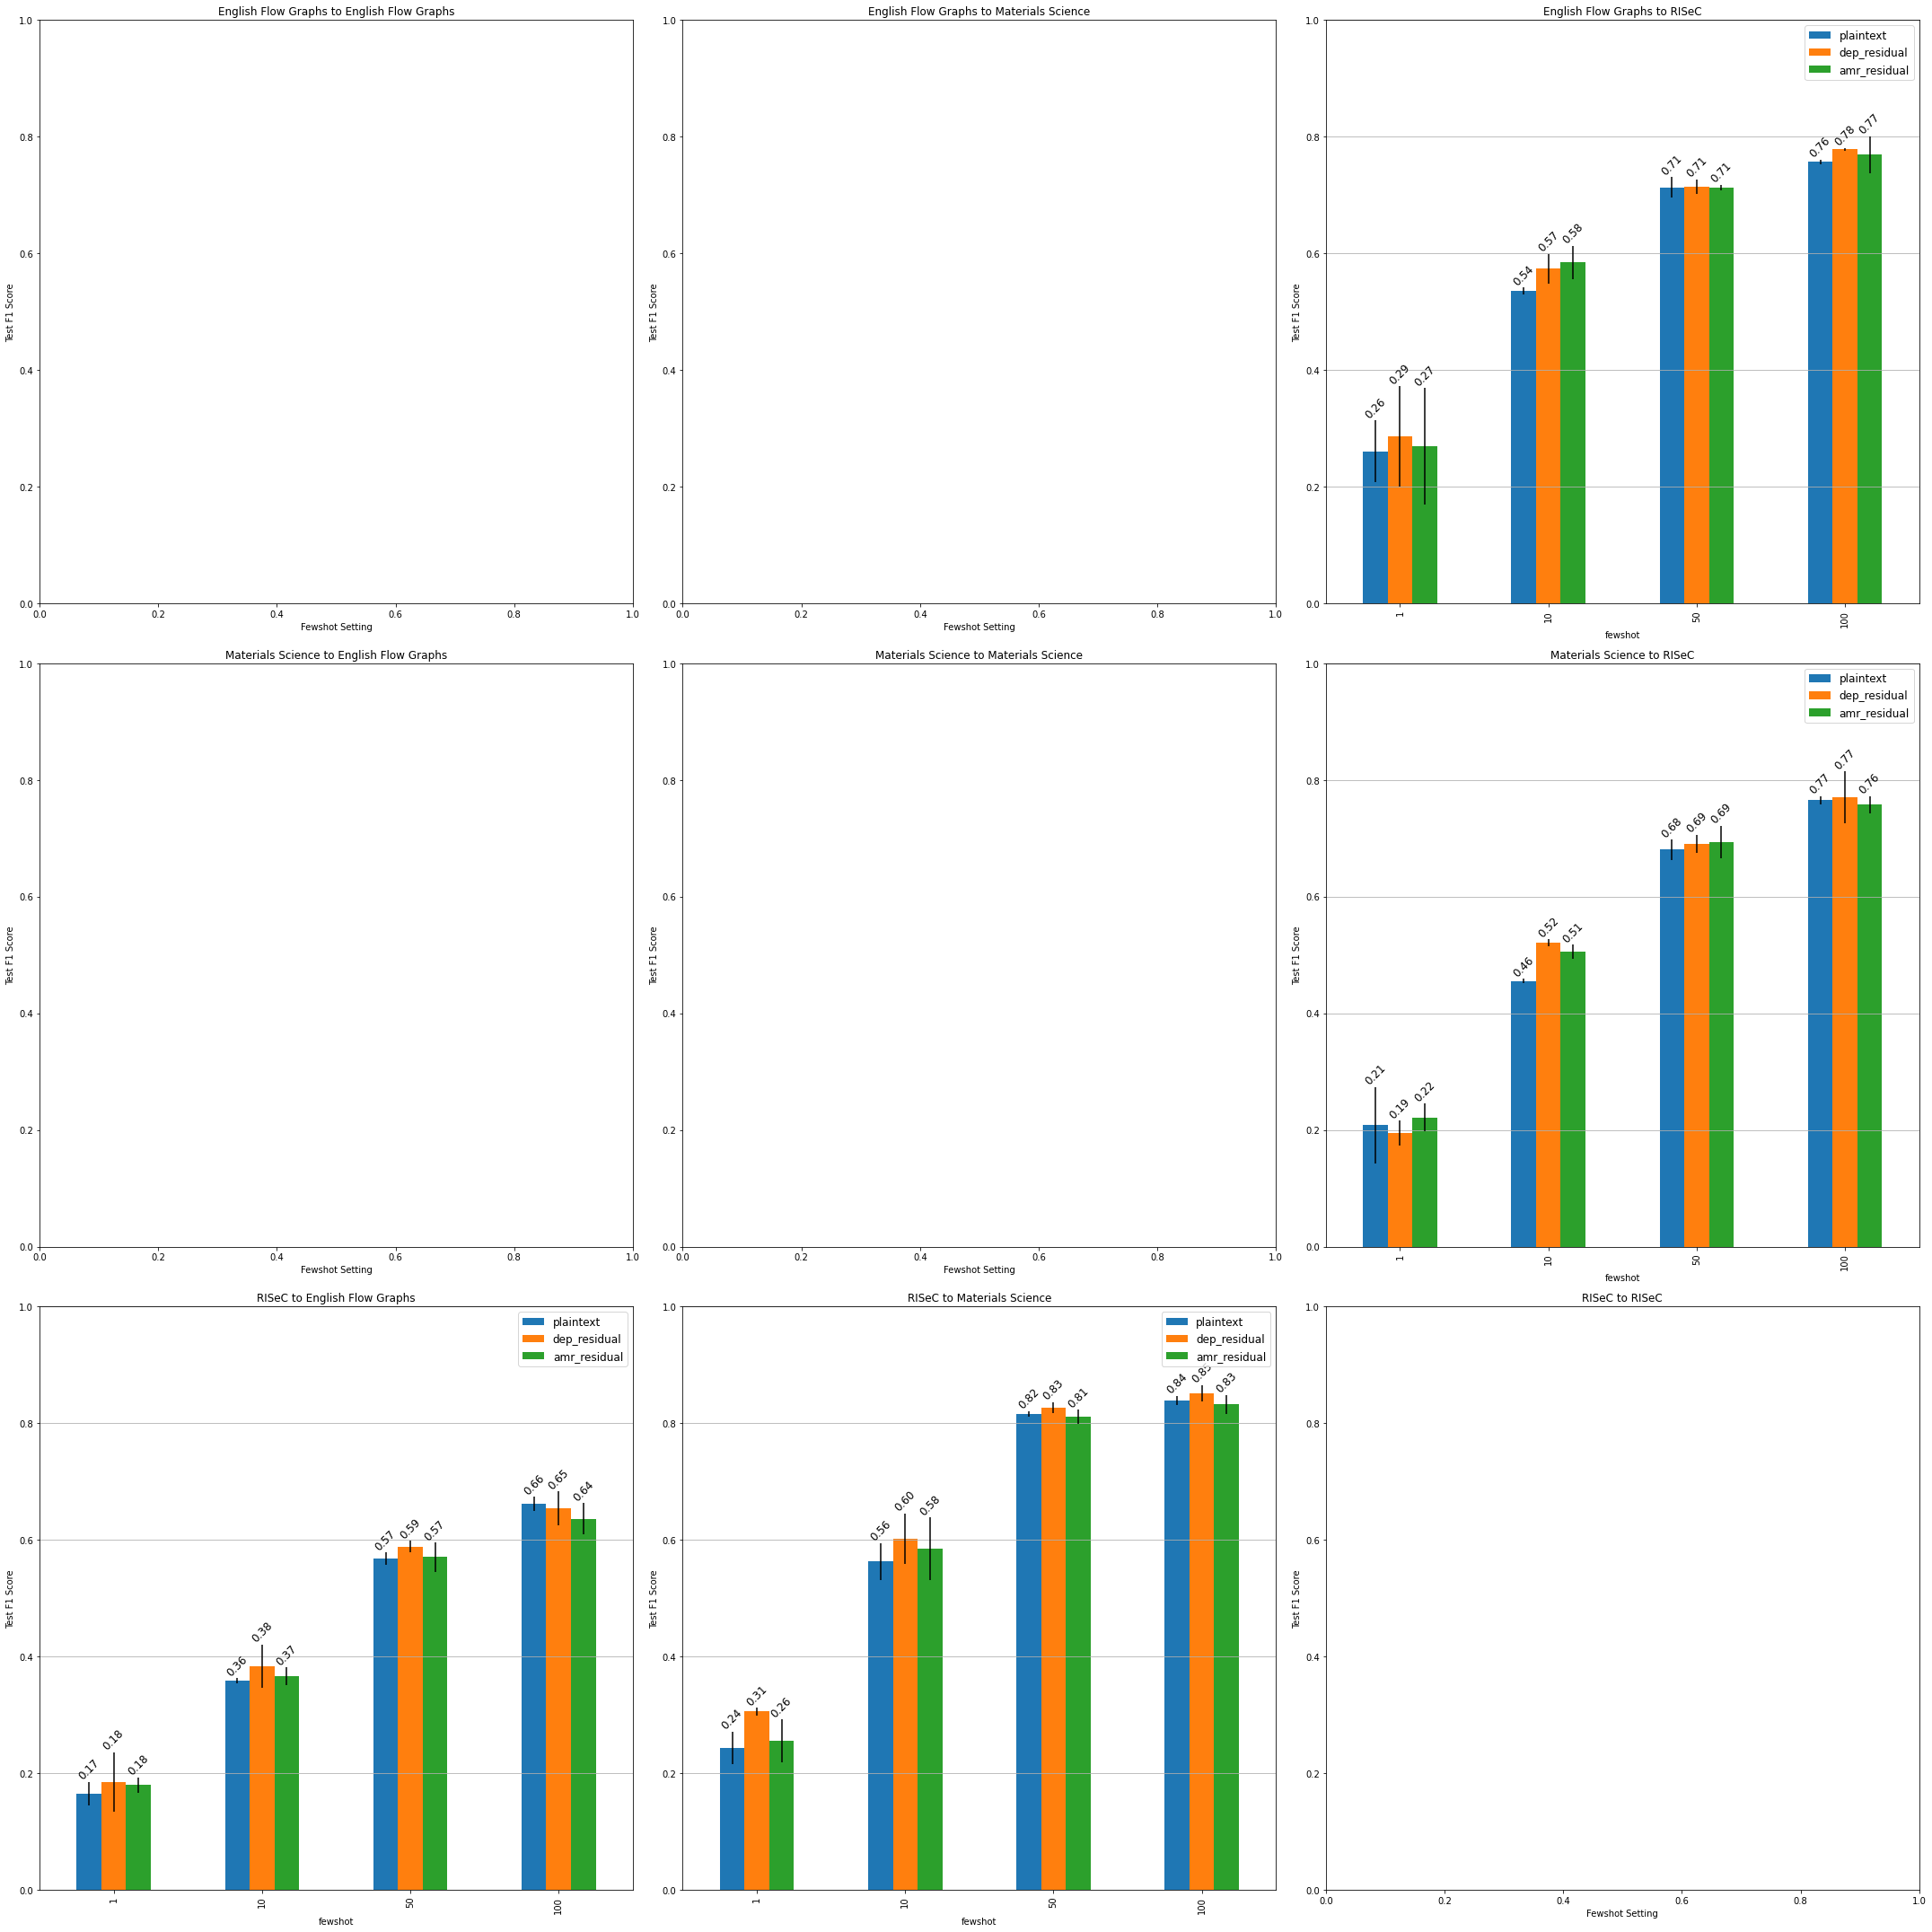

In [9]:
matplotlib.rcParams.update({'font.size': 22})

src_datasets = set(results_df["src_dataset"])
tgt_datasets = set(results_df["tgt_dataset"])

fig, axes = plt.subplots(len(tgt_datasets),len(src_datasets), figsize=(len(src_datasets) * 10, len(tgt_datasets) * 10), tight_layout=True)
ax_iter = iter(axes.reshape([-1]))

for src_dataset in sorted(src_datasets):
    for i, tgt_dataset in enumerate(sorted(tgt_datasets)):
        ax = next(ax_iter)

        ax.set_title(f"{dataset_name_mapping[src_dataset]} to {dataset_name_mapping[tgt_dataset]}")
        ax.set_ylim(0, 1)
        ax.set_xlabel("Fewshot Setting")
        ax.set_ylabel("Test F1 Score")
        if src_dataset == tgt_dataset:
            continue
        results_viz = results_df[(results_df["src_dataset"] == src_dataset) & (results_df["tgt_dataset"] == tgt_dataset)].groupby(["fewshot", "case"])["test_f1"].aggregate(["mean", "std"]).unstack(1)
        if len(results_viz) == 0:
            continue
        graph = results_viz["mean"][["plaintext", "dep_residual", "amr_residual"]].plot.bar(ax=ax, yerr=results_viz["std"])
        graph.grid(axis="y", which="both")

        ax.legend(fontsize=12)


        for bars in ax.containers:
            try:
                ax.bar_label(bars, fmt="%2.2f", rotation=45, fontsize=12)
            except:
                pass


In [10]:
unstacked = results_df.groupby(["src_dataset", "tgt_dataset", "fewshot", "case"])["test_f1"].mean().unstack(-1)
unstacked

case                             amr_residual  dep_residual  plaintext
src_dataset tgt_dataset fewshot                                       
japflow     risec       1            0.269530      0.286168   0.261064
                        10           0.584702      0.573842   0.535515
                        50           0.713293      0.714774   0.713394
                        100          0.769259      0.778683   0.757034
mscorpus    risec       1            0.221644      0.194171   0.208031
                        10           0.505041      0.520884   0.455464
                        50           0.693449      0.690586   0.680365
                        100          0.757448      0.770039   0.765277
risec       japflow     1            0.179330      0.184946   0.165237
                        10           0.366268      0.383476   0.358775
                        50           0.570582      0.588189   0.567728
                        100          0.636158      0.654126   0.661108
            mscorpus    1            0.255071      0.305718   0.243335
                        10           0.584934      0.601695   0.562776
                        50           0.810753      0.826933   0.815441
                        100          0.832080      0.851637   0.839315